## Model-based RL

Implement a policy and model network, which work in tandem to solve the CartPole reinforcement learning problem.

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf

%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Policy Network

In [3]:
# hyperparams:

n_hidden = 8
learning_rate = 1e-2
gamma = 0.99  # discount factor for reward
model_batch_size = 3  # Batch size when learning from model
real_batch_size = 3  # Batch size when learning from real environment
obs_dim = 4  # input dimensionality

In [4]:
tf.reset_default_graph()

In [5]:
observations = tf.placeholder(tf.float32, [None, obs_dim], name='input_X')
W1 = tf.get_variable('W1', shape=[obs_dim, n_hidden], initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations, W1))
W2 = tf.get_variable('W2', shape=[n_hidden, 1], initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1, W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32, [None, 1], name='input_y')
advantage = tf.placeholder(tf.float32, name='reward_signal')

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

W1_grad = tf.placeholder(tf.float32, name='batch_grad1')
W2_grad = tf.placeholder(tf.float32, name='batch_grad2')
batch_grads = [W1_grad, W2_grad]

loglik = tf.log(input_y * (input_y - probability) + (1 - input_y) * (input_y + probability))
loss = -tf.reduce_mean(loglik * advantage)

new_grads = tf.gradients(loss, tvars)
update_grads = optimizer.apply_gradients(zip(batch_grads, tvars))

### Model Network

Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from the current state and action.

In [6]:
model_n_hidden = 256

input_data = tf.placeholder(tf.float32, [None, 5])

with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable('softmax_w', [model_n_hidden, 50])
    softmax_b = tf.get_variable('softmax_b', [50])
    
prev_state = tf.placeholder(tf.float32, [None, 5], name='prev_state')
W1_model = tf.get_variable('W1_model', shape=[5, model_n_hidden],
                           initializer=tf.contrib.layers.xavier_initializer())
b1_model = tf.Variable(tf.zeros([model_n_hidden]), name='b1_model')
layer1_model = tf.nn.relu(tf.matmul(prev_state, W1_model) + b1_model)
W2_model = tf.get_variable('W2_model', shape=[model_n_hidden, model_n_hidden],
                           initializer=tf.contrib.layers.xavier_initializer())
b2_model = tf.Variable(tf.zeros([model_n_hidden]), name='b2_model')
layer2_model = tf.nn.relu(tf.matmul(layer1_model, W2_model) + b2_model)

w_obs = tf.get_variable('w_obs', shape=[model_n_hidden, 4],
                        initializer=tf.contrib.layers.xavier_initializer())
w_reward = tf.get_variable('w_reward', shape=[model_n_hidden, 1],
                           initializer=tf.contrib.layers.xavier_initializer())
w_done = tf.get_variable('w_done', shape=[model_n_hidden, 1],
                         initializer=tf.contrib.layers.xavier_initializer())

b_obs = tf.Variable(tf.zeros([4]), name='b_obs')
b_reward = tf.Variable(tf.zeros([1]), name='b_reward')
b_done = tf.Variable(tf.ones([1]), name='b_done')

pred_obs = tf.matmul(layer2_model, w_obs, name='pred_obs') + b_obs
pred_reward = tf.matmul(layer2_model, w_reward, name='pred_reward') + b_reward
pred_done = tf.sigmoid(tf.matmul(layer2_model, w_done, name='pred_done') + b_done)

true_obs = tf.placeholder(tf.float32, [None, 4], name='true_obs')
true_reward = tf.placeholder(tf.float32, [None, 1], name='true_reward')
true_done = tf.placeholder(tf.float32, [None, 1], name='true_done')

pred_state = tf.concat([pred_obs, pred_reward, pred_done], axis=1)

loss_obs = tf.square(true_obs - pred_obs)
loss_reward = tf.square(true_reward - pred_reward)
loss_done = -tf.log(tf.multiply(pred_done, true_done) + tf.multiply(1 - pred_done, 1 - true_done))

loss_model = tf.reduce_mean(loss_obs + loss_reward + loss_done)
optimizer_model = tf.train.AdamOptimizer(learning_rate)
update_model = optimizer_model.minimize(loss_model)

### Helper functions

In [7]:
def reset_grad_buffer(grad_buffer):
    if type(grad_buffer) is not np.ndarray:
        grad_buffer = np.array(grad_buffer)
        
    grad_buffer *= 0
    return grad_buffer

In [8]:
def discount_rewards(rewards, gamma=0.99):
    """ take 1D float array of rewards and compute discounted rewards """
    discounted = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(0, len(rewards))):
        running_add = running_add * gamma + rewards[t]
        discounted[t] = running_add
        
    return discounted

In [9]:
def step_model(sess, xs, action):
    """
    This function uses our model to produce a new state
    when given a previous state and action.
    """
    pred = sess.run(pred_state, feed_dict={
        prev_state: np.reshape(np.hstack([xs[-1][0], np.array(action)]), [1, 5])
    })
    reward = pred[:, 4]
    obs = pred[:, 0:4]
    obs[:, 0] = np.clip(obs[:, 0], -2.4, 2.4)
    obs[:, 2] = np.clip(obs[:, 2], -0.4, 0.4)
    p_done = np.clip(pred[:, 5], 0, 1)
    done = (p_done > 0.1 or len(xs) >= 300)
    
    return obs, reward, done

### Training the Policy and Model

In [10]:
xs, ys, rs, ds = [], [], [], []
running_reward = None
reward_sum = 0
episode_num = 1
real_episodes = 1
batch_size = real_batch_size

draw_from_model = False  # When set to True, will use model for observations
train_model = True  # Whether to train the model
train_policy = False  # Whether to train the policy
switch_point = 1

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    rendering = False
    obs = env.reset()
    x = obs
    grad_buffer = sess.run(tvars)
    grad_buffer = reset_grad_buffer(grad_buffer)
    
    while episode_num < 5000:
        # Start displaying environment once performance is acceptably high
        if rendering or (reward_sum / batch_size > 150 and not draw_from_model):
            env.render()
            rendering = True
            
        x = np.reshape(obs, [1, 4])
        prob = sess.run(probability, feed_dict={observations: x})
        action = 1 if np.random.uniform() < prob else 0
        
        xs.append(x)
        y = 1 if action == 0 else 0
        ys.append(y)
        
        if draw_from_model:
            obs, reward, done = step_model(sess, xs, action)
        else:
            obs, reward, done, _ = env.step(action)
            
        reward_sum += reward
        rs.append(reward)  # record reward (has to be done after we call step() to get reward for previous action)
        ds.append(done * 1)
        
        if done:
            if not draw_from_model:
                real_episodes += 1
                
            episode_num += 1
            
            # stack together all inputs, hidden states, action gradients, 
            # and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(rs)
            epd = np.vstack(ds)
            xs, ys, rs, ds = [], [], [], []  # reset memory
            
            if train_model:
                actions = np.array([np.abs(y - 1) for y in epy][:-1])
                prev_states = epx[:-1, :]
                prev_states = np.hstack([prev_states, actions])
                next_states = epx[1:, :]
                rewards = np.array(epr[1:, :])
                dones = np.array(epd[1:, :])
                next_states_all = np.hstack([next_states, rewards, dones])
                feed_dict = {
                    prev_state: prev_states,
                    true_obs: next_states,
                    true_done: dones,
                    true_reward: rewards
                }
                loss, p_state, _ = sess.run([loss_model, pred_state, update_model], feed_dict)
                
            if train_policy:
                discounted_epr = discount_rewards(epr).astype('float32')
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                grads_t = sess.run(new_grads, feed_dict={
                    observations: epx,
                    input_y: epy,
                    advantage: discounted_epr
                })
                
                # If gradients become too large, end training process
                if np.sum(grads_t[0] == grads_t[0]) == 0:
                    print('Gradients too large!')
                    break
                    
                for i, grad in enumerate(grads_t):
                    grad_buffer[i] += grad
                    
            if switch_point + batch_size == episode_num:
                switch_point = episode_num
                
                if train_policy:
                    sess.run(update_grads, feed_dict={
                        W1_grad: grad_buffer[0],
                        W2_grad: grad_buffer[1]
                    })
                    grad_buffer = reset_grad_buffer(grad_buffer)
                    
                if running_reward is None:
                    running_reward = reward_sum
                else:
                    running_reward = running_reward * 0.99 + reward_sum * 0.01
                    
                if not draw_from_model:
                    print('World Perf: Episode %i  Reward %f  action: %i  mean reward %f' % 
                          (real_episodes, reward_sum / real_batch_size, action, 
                           running_reward / real_batch_size))

                    if reward_sum / batch_size > 200:
                        break

                reward_sum = 0

                # Once the model has been trained on 100 episodes,
                # we start alternating between training the policy
                # from the model and training the model from the 
                # real environment.
                if episode_num > 100:
                    draw_from_model = not draw_from_model
                    train_model = not train_model
                    train_policy = not train_policy

            if draw_from_model:
                obs = np.random.uniform(-0.1, 0.1, [4])  # Generate reasonable starting point
                batch_size = model_batch_size
            else:
                obs = env.reset()
                batch_size = real_batch_size
                
print('Num real episodes:', real_episodes)

World Perf: Episode 4  Reward 19.666667  action: 0  mean reward 19.666667
World Perf: Episode 7  Reward 14.000000  action: 1  mean reward 19.610000
World Perf: Episode 10  Reward 23.333333  action: 1  mean reward 19.647233
World Perf: Episode 13  Reward 37.000000  action: 0  mean reward 19.820761
World Perf: Episode 16  Reward 12.666667  action: 0  mean reward 19.749220
World Perf: Episode 19  Reward 15.333333  action: 0  mean reward 19.705061
World Perf: Episode 22  Reward 12.666667  action: 1  mean reward 19.634677
World Perf: Episode 25  Reward 11.666667  action: 1  mean reward 19.554997
World Perf: Episode 28  Reward 20.000000  action: 0  mean reward 19.559447
World Perf: Episode 31  Reward 17.333333  action: 0  mean reward 19.537186
World Perf: Episode 34  Reward 26.000000  action: 0  mean reward 19.601814
World Perf: Episode 37  Reward 18.333333  action: 0  mean reward 19.589129
World Perf: Episode 40  Reward 13.000000  action: 0  mean reward 19.523238
World Perf: Episode 43  Rew

KeyboardInterrupt: 

### Checking model representation

Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


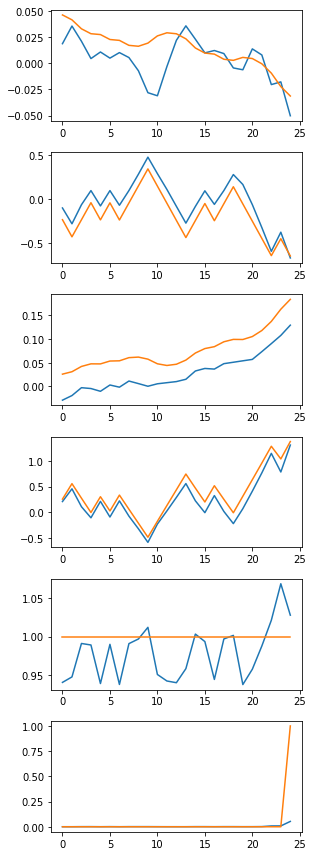

In [11]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2 * i + 1)
    plt.plot(p_state[:, i])
    plt.subplot(6, 2, 2 * i + 1)
    plt.plot(next_states_all[:, i])
    
plt.tight_layout()